## Load and prepare the dataset

In [2]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display
import tensorflow as tf


In [40]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype("float32")
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [3]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [ ]:
# Batch and Shuffle the train data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Create the Generator model using keras Sequential API

In [4]:
# Create Generator Model
generator_model = tf.keras.Sequential([
    layers.Dense(7*7*256, use_bias=False, input_shape=(100,)),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Reshape((7, 7, 256)),
    layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding="same", use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding="same", use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding="same", use_bias=False, activation="tanh"),
])

In [5]:
# Create Discriminator Model
discriminator_model = tf.keras.Sequential([
    layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same", input_shape=[28, 28, 1]),
    layers.LeakyReLU(),
    layers.Dropout(0.3),

    layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same"),
    layers.LeakyReLU(),
    layers.Dropout(0.3),

    layers.Flatten(),
    layers.Dense(1)
])

## Generate Random image and discriminate it.

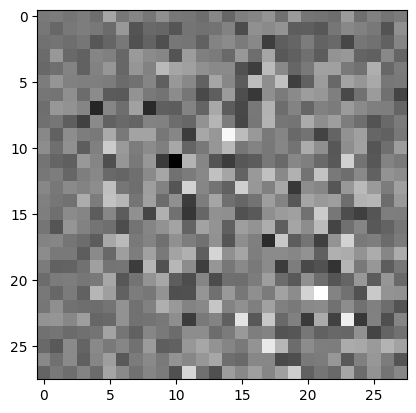

In [ ]:
noise = tf.random.normal([1, 100])
generated_image = generator_model(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap="gray")

In [ ]:
decision = discriminator_model(generated_image)
print(decision)

tf.Tensor([[0.0001687]], shape=(1, 1), dtype=float32)


## Define the loss and Optimizers

In [6]:
# get helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [7]:
# Create Discriminator loss and optimizers
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [8]:
# Create Generator loss and optimizers
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)

## Save checkpoints

In [9]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator_model,
                                 discriminator=discriminator_model)

# Define the training loop

In [9]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 10

# Set the seed
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [10]:
# Compile the function
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator_model(noise, training = True)

    real_output = discriminator_model(images, training = True)
    fake_output = discriminator_model(generated_images, training = True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator_model.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator_model.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator_model.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator_model.trainable_variables))

## Generate and save images

In [11]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False) # training set to false so that all layers run in inference model

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap="gray")
    plt.axis("off")

  plt.savefig("image_at_epoch_{:04d}.png".format(epoch))
  plt.show()

In [12]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator_model,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print(f"Time for epoch {epoch + 1} is {time.time()-start} sec")

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator_model,
                           epochs,
                           seed)

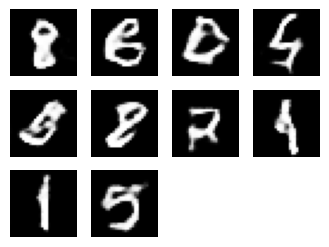

In [ ]:
# train the model
train(train_dataset, EPOCHS)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Create a GIF

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

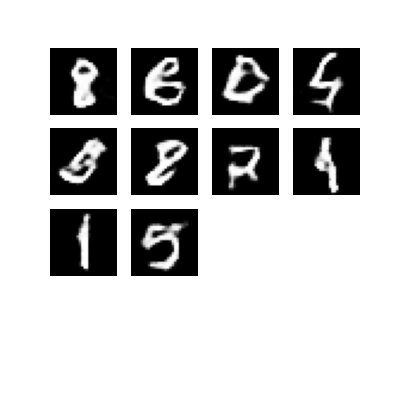

In [ ]:
display_image(EPOCHS)

In [ ]:
# Create an animated gif using the images saved during training
anim_file ="dcgan.gif"

with imageio.get_writer(anim_file, mode="I") as writer:
  filenames = glob.glob("image*.png")
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-62-82f17a00ee06>:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-62-82f17a00ee06>:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [ ]:
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done



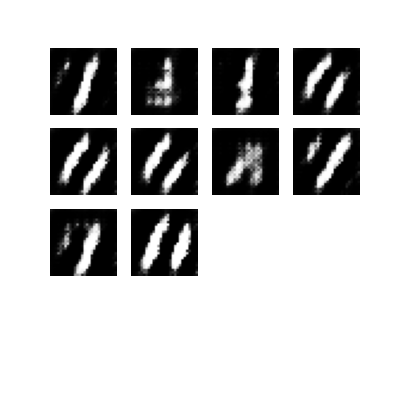

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

In [ ]:
from google.colab import files
files.download(anim_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

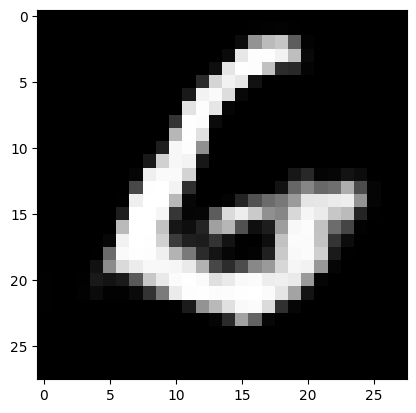

In [ ]:
noise = tf.random.normal([1, 100])
generated_image = generator_model(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap="gray")

In [13]:
import tensorflow_datasets as tfds
datasets_list = tfds.list_builders()

In [14]:
print("stanford_dogs" in datasets_list)

True


In [15]:
(test_dog_data, train_dog_data), ds_info = tfds.load(name="stanford_dogs",
                                             split=["test", "train"],
                                             shuffle_files=True,
                                             as_supervised=True, # data gets returned in tuple format (data, label)
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteYMY5UF/stanford_dogs-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteYMY5UF/stanford_dogs-test.tfrecord*...:   0%…

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


In [ ]:
test_dog_images  = []
for images, labels in test_dog_data:
  test_dog_images.append(images)

In [27]:
train_dog_images = {}
for images, labels in train_dog_data:
  train_dog_images.append(images.numpy())

KeyboardInterrupt: ignored

In [16]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'image/filename': Text(shape=(), dtype=string),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=float32),
    }),
})

In [28]:
train_one_sample = train_dog_images[1]

In [46]:
  print(f"""
  Image shape: {train_one_sample.shape},
  Image datatype: {image.dtype},
  Target class from stanford_dogs (tensor form): {label}
  """)


Image shape: (747, 560, 3),
Image datatype: uint8,
Target class from stanford_dogs (tensor form): 63



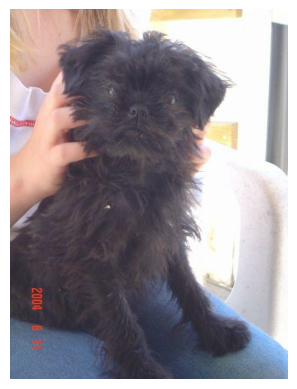

In [47]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(train_one_sample)# Add title to image to verify the label is associated with the right image
plt.axis(False);

In [34]:
# Make a function for preprocessing images
def preprocess_img(image):
  image = image.reshape(train_images.shape[0], 28, 28, 1)
  # image = tf.image.resize(train_images.shape[0], 28, 28, 1)
  image = (image - 127.5) / 127.5
  return tf.cast(image, tf.float32)

In [49]:
# Batch and Shuffle the train data
train_dog_dataset = tf.data.Dataset.from_tensor_slices(train_dog_images_tensor).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Map preprocessing function to test data (and parallelize)
test_dog_data = tf.data.Dataset.from_tensor_slices(test_dog_images_tensor).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

ValueError: ignored

In [39]:
train_dog_data

<_PrefetchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [24]:
# Create ModelCheckpoint callback to save a model's progress during training
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

In [ ]:
train(train_dog_data, EPOCHS)